# Import thư viện

In [1]:
%load_ext autotime

time: 63.2 μs (started: 2025-01-27 00:46:34 +07:00)


In [2]:
import os
import cv2
import dill
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import fftconvolve
from scipy.signal import convolve2d
from numpy.lib.stride_tricks import sliding_window_view

time: 931 ms (started: 2025-01-27 00:46:36 +07:00)


# Tạo dataset

In [3]:
def load_data_from_directory(directory_path, lr_size=(240, 240), hr_size=(480, 480)):
    """
    Tải dữ liệu từ thư mục và chia thành các patch nhỏ cho cả ảnh LR và HR.

    Tham số:
    - directory_path (str): Đường dẫn tới thư mục chứa các ảnh LR và HR.
    - lr_size (tuple, mặc định (240, 240)): Kích thước mà ảnh LR sẽ được thay đổi kích thước về.
    - hr_size (tuple, mặc định (480, 480)): Kích thước mà ảnh HR sẽ được thay đổi kích thước về.
    - patch_size (int, mặc định 60): Kích thước của mỗi patch được chia từ ảnh LR. Các patch HR sẽ có kích thước gấp đôi (patch_size*2).

    Lý thuyết hoạt động:
    - Hàm này tìm các ảnh có tên kết thúc bằng '_LR.png' trong thư mục chỉ định.
    - Tạo tên ảnh HR tương ứng bằng cách thay thế phần '_LR.png' bằng '_HR.png'.
    - Nếu ảnh HR tồn tại, nó sẽ được tải cùng với ảnh LR.
    - Các ảnh LR và HR sẽ được thay đổi kích thước về các giá trị `lr_size` và `hr_size` tương ứng.
    - Ảnh sau đó sẽ được chuẩn hóa về phạm vi giá trị [0, 1] (định dạng float32).
    - Mỗi ảnh sẽ được chia thành các patch nhỏ có kích thước `patch_size` cho ảnh LR và `patch_size*2` cho ảnh HR.
    - Tất cả các patch của ảnh LR và HR sẽ được thu thập và trả về.

    Trả về:
    - lr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh LR.
      Mảng có kích thước (n, patch_size, patch_size), trong đó n là số lượng patch.
    - hr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh HR.
      Mảng có kích thước (n, patch_size*2, patch_size*2), trong đó n là số lượng patch.

    Ví dụ:
    >>> lr_images, hr_images = load_data_from_directory('path/to/directory', lr_size=(240, 240), hr_size=(480, 480))
    >>> print(lr_images.shape)
    (n, 60, 60)  # n là số lượng patch LR
    >>> print(hr_images.shape)
    (n, 120, 120)  # n là số lượng patch HR

    Lưu ý:
    - Hàm yêu cầu các ảnh LR phải có tên kết thúc bằng '_LR.png' và ảnh HR tương ứng phải có tên kết thúc bằng '_HR.png'.
    - Chỉ các ảnh có cả hai tệp LR và HR sẽ được xử lý.
    """
    
    lr_images = []
    hr_images = []

    # Lặp qua tất cả các file trong thư mục
    for filename in os.listdir(directory_path):
        if filename.endswith('_LR.png'):  # Tìm ảnh LR
            # Tạo tên ảnh HR tương ứng
            hr_filename = filename.replace('_LR.png', '_HR.png')

            # Xây dựng đường dẫn đầy đủ cho ảnh LR và HR
            lr_path = os.path.join(directory_path, filename)
            hr_path = os.path.join(directory_path, hr_filename)

            if os.path.exists(hr_path):  # Kiểm tra xem ảnh HR có tồn tại không
                # Đọc ảnh LR và HR
                
                lr_img = cv2.imread(lr_path)  # Đọc ảnh màu
                hr_img = cv2.imread(hr_path)  # Đọc ảnh màu
                
                lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB
                hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB
                
                # lr_img = cv2.imread(lr_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale (xám)
                # hr_img = cv2.imread(hr_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale (xám)

                if lr_img is not None and hr_img is not None:
                    # Resize ảnh về kích thước mong muốn
                    lr_img = cv2.resize(lr_img, lr_size)
                    hr_img = cv2.resize(hr_img, hr_size)

                    # Chuẩn hóa ảnh (0-1)
                    lr_img = lr_img.astype('float32') / 255.0
                    hr_img = hr_img.astype('float32') / 255.0
                    
                    lr_img = np.transpose(lr_img, (2, 0, 1))
                    hr_img = np.transpose(hr_img, (2, 0, 1))

                    # Thêm các ảnh vào danh sách
                    lr_images.append(lr_img)
                    hr_images.append(hr_img)

    return lr_images, hr_images

time: 1.18 ms (started: 2025-01-27 00:46:38 +07:00)


In [4]:
directory_path = '/home/vodanhday/Downloads/BSD100/image_SRF_2'

lr_size = (240, 240)
hr_size = (480, 480)

lr_images, hr_images = load_data_from_directory(directory_path, lr_size, hr_size)

time: 645 ms (started: 2025-01-27 00:46:41 +07:00)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(lr_images), np.array(hr_images), test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(len(X_train), len(X_val), len(X_test))

72 8 20
time: 313 ms (started: 2025-01-27 00:46:42 +07:00)


# Thực hiện xây dựng model

In [10]:
class Layer:
    def __init__(self):
        self.shape = {'input': None, 'output': None}
        self.weights = None
        self.bias = None
        self.activation = None
        self.scale = None
        self.feature_map = {'Z': None, 'A': None, 'A_prev': None}
        self.gradient = {'dW': None, 'db': None, 'dA': None, 'dZ': None, 'dgamma': None, 'dbeta': None}
        self.conv = {'stride': None, 'padding': None, 'kernel_size': None, 'num_filters': None}
        self.batch_norm = {'gamma': None, 'beta': None, 'mean': None, 'var': None, 'epsilon': None, 'momentum': None}
        self.names = []

    def Input(self, shape):
        self.shape['input'] = self.shape['output'] = shape
        self.names.append('Input')
        return self

    def Upscale(self, scale=2):
        h, w, c = self.shape['input']
        self.shape['output'] = [h * scale, w * scale, c]
        self.scale = scale
        self.names.append('Upscale')
        return self

    def Conv2D(self, num_filters, kernel_size, stride=1, padding="same", activation=None):
        self.weights = np.random.randn(kernel_size, kernel_size, self.shape['input'][2], num_filters) * 0.01
        self.bias = np.zeros((1, 1, 1, num_filters))

        padding_value = {'same': (kernel_size - stride) // 2, 'valid': 0}.get(padding, padding)
        if isinstance(padding_value, int):
            self.conv.update({'stride': stride, 'padding': padding_value,
                              'kernel_size': kernel_size, 'num_filters': num_filters})
        else:
            raise ValueError(f"Unsupported padding '{padding}'.")

        h, w, _ = self.shape['input']
        self.shape['output'] = [
            (h - kernel_size + 2 * padding_value) // stride + 1,
            (w - kernel_size + 2 * padding_value) // stride + 1,
            num_filters
        ]
        self.activation = activation
        self.names.append('Conv2D')
        if activation:
            self.names.append('Activation')
        return self

    def BatchNormalization(self, epsilon=1e-5, momentum=0.9):
        self.batch_norm['gamma'] = np.ones((1, 1, 1, self.shape['output'][2]))
        self.batch_norm['beta'] = np.zeros((1, 1, 1, self.shape['output'][2]))
        self.batch_norm['epsilon'] = epsilon
        self.batch_norm['momentum'] = momentum
        self.names.append('BatchNormalization')
        return self

    def activate(self, Z):
        if self.activation == "relu":
            return np.maximum(0, Z)
        return Z

    def activate_derivative(self, Z):
        if self.activation == "relu":
            return (Z > 0).astype(float)
        return np.ones_like(Z)

    def forward(self, A_prev):
        self.feature_map['A_prev'] = A_prev
        A = A_prev
        for name in self.names:
            if name == 'Upscale':
                scale = self.scale
                A = A.repeat(scale, axis=1).repeat(scale, axis=2)
            elif name == 'Conv2D':
                A = self._forward_conv2d(A)
            elif name == 'BatchNormalization':
                A = self._forward_batchnorm(A)
            elif name == 'Activation':
                A = self.activate(self.feature_map['Z'])
        self.feature_map['A'] = A
        return A

    def _forward_conv2d(self, A_prev):
        A_col = self.im2col(A_prev)
        W_col = self.weights.reshape(-1, self.conv['num_filters'])

        Z = np.dot(A_col.T, W_col) + self.bias.reshape(-1)

        n, h_out, w_out, c_out = A_prev.shape[0], *self.shape['output']
        Z = Z.reshape(n, h_out, w_out, c_out)

        self.feature_map['Z'] = Z
        return Z

    def _forward_batchnorm(self, A_prev):
        gamma = self.batch_norm['gamma']
        beta = self.batch_norm['beta']
        epsilon = self.batch_norm['epsilon']

        mean = np.mean(A_prev, axis=(0, 1, 2), keepdims=True)
        var = np.var(A_prev, axis=(0, 1, 2), keepdims=True)

        self.batch_norm['mean'] = mean
        self.batch_norm['var'] = var

        A_norm = (A_prev - mean) / np.sqrt(var + epsilon)
        A_out = gamma * A_norm + beta

        self.feature_map['A_norm'] = A_norm
        self.feature_map['A_prev'] = A_prev

        return A_out

    def backward(self, dA):
        for name in reversed(self.names):
            if name == 'Upscale':
                scale = self.scale
                dA = dA[:, ::scale, ::scale, :]
            elif name == 'Activation':
                dA *= self.activate_derivative(self.feature_map['Z'])
            elif name == 'BatchNormalization':
                dA = self._backward_batchnorm(dA)
            elif name == 'Conv2D':
                dA = self._backward_conv2d(dA)
        return dA

    def _backward_conv2d(self, dA):
        A_prev = self.feature_map['A_prev']
        A_prev_col = self.im2col(A_prev)
        A_prev_col = A_prev_col.reshape(-1, A_prev_col.shape[-1])

        dZ_col = dA.reshape(-1, self.conv['num_filters'])

        self.gradient['dW'] = (A_prev_col @ dZ_col).reshape(self.weights.shape)
        self.gradient['db'] = dZ_col.sum(axis=0).reshape(self.bias.shape)
        
        rotated_kernel = np.rot90(self.weights, 2, axes=(0, 1))

        W_col = rotated_kernel.reshape(-1, self.conv['num_filters'])
        dA_col = dZ_col @ W_col.T
        dA_prev = self.col2im(dA_col)

        return dA_prev

    def _backward_batchnorm(self, dA):
        A_prev = self.feature_map['A_prev']
        A_norm = self.feature_map['A_norm']
        gamma = self.batch_norm['gamma']
        beta = self.batch_norm['beta']
        epsilon = self.batch_norm['epsilon']
        mean = self.batch_norm['mean']
        var = self.batch_norm['var']

        N, H, W, C = A_prev.shape

        dgamma = np.sum(dA * A_norm, axis=(0, 1, 2), keepdims=True)
        dbeta = np.sum(dA, axis=(0, 1, 2), keepdims=True)

        dA_norm = dA * gamma

        dvar = np.sum(dA_norm * (A_prev - mean) * -0.5 * (var + epsilon) ** -1.5, axis=(0, 1, 2), keepdims=True)

        dmean = np.sum(dA_norm * -1 / np.sqrt(var + epsilon), axis=(0, 1, 2), keepdims=True) + \
                dvar * np.sum(-2 * (A_prev - mean), axis=(0, 1, 2), keepdims=True) / (N * H * W)

        dA_prev = dA_norm / np.sqrt(var + epsilon) + \
                dvar * 2 * (A_prev - mean) / (N * H * W) + \
                dmean / (N * H * W)

        self.gradient['dgamma'] = dgamma
        self.gradient['dbeta'] = dbeta

        return dA_prev
    
    def get_indices(self, X_shape):
        pad = self.conv['padding']
        stride = self.conv['stride']
        kernel_size = self.conv['kernel_size']
        m, n_H, n_W, n_C = X_shape

        out_h = int((n_H + 2 * pad - kernel_size) / stride) + 1
        out_w = int((n_W + 2 * pad - kernel_size) / stride) + 1
    
        level1 = np.repeat(np.arange(kernel_size), kernel_size)
        level1 = np.tile(level1, n_C)
        everyLevels = stride * np.repeat(np.arange(out_h), out_w)
        i = level1.reshape(-1, 1) + everyLevels.reshape(1, -1)

        slide1 = np.tile(np.arange(kernel_size), kernel_size)
        slide1 = np.tile(slide1, n_C)
        everySlides = stride * np.tile(np.arange(out_w), out_h)
        j = slide1.reshape(-1, 1) + everySlides.reshape(1, -1)

        d = np.repeat(np.arange(n_C), kernel_size * kernel_size).reshape(-1, 1)

        return i, j, d

    def im2col(self, A):
        A_padded = self.add_padding(A)
        i, j, d = self.get_indices(A.shape)
        
        cols = A_padded[:, i, j, d]
        cols = np.concatenate(cols, axis=-1)
        return cols

    def col2im(self, cols):
        pad = self.conv['padding']
        n, h, w, c = self.feature_map['A_prev'].shape

        A_padded = np.zeros((n, h + 2 * pad, w + 2 * pad, c))
        
        i, j, d = self.get_indices((n, h, w, c))
        
        cols_reshaped = np.array(np.hsplit(cols.T, n))
        
        np.add.at(A_padded, (slice(None), i, j, d), cols_reshaped)
        
        if pad == 0:
            return A_padded
        elif type(pad) is int:
            return A_padded[:, pad:-pad, pad:-pad, :] 

    def add_padding(self, A):
        p = self.conv['padding']
        return np.pad(A, ((0, 0), (p, p), (p, p), (0, 0)), mode='constant')

    def update_params(self, lr):
        if self.gradient['dW'] is None or self.gradient['db'] is None:
            return
        else:
            for name in self.names:
                if name == 'Conv2D':
                    self.weights -= lr * self.gradient['dW']
                    self.bias -= lr * self.gradient['db']
                elif name == 'BatchNormalization':
                    self.batch_norm['gamma'] -= lr * self.gradient['dgamma']
                    self.batch_norm['beta'] -= lr * self.gradient['dbeta']

    def get_params(self):
        return {k: getattr(self, k) for k in ['weights', 'bias', 'activation', 'shape', 'conv', 'gradient', 'feature_map', 'names']}

    def set_params(self, params):
        for k, v in params.items():
            setattr(self, k, v)
        return self

time: 4.64 ms (started: 2025-01-25 17:28:03 +07:00)


In [11]:
class SRCNN:
    def __init__(self):
        self.layers = []
        self.optimizer = {'loss_fn': None, 'metrics': []}
        self.current_shape = None
        self.best_weights = None
        self.learning_rate = None
        self.continue_training = False
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_metric': {},
            'val_metric': {}
        }

    def add(self, layer):
        """Thêm một lớp vào mô hình."""
        self.current_shape = layer.shape['output']
        self.layers.append(layer)

    def forward(self, X):
        """Lan truyền xuôi."""
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, output, Y, learning_rate):
        """Lan truyền ngược và cập nhật tham số."""
        dA = self._calculate_gradient(output, Y, self.optimizer['loss_fn'].__name__)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
            layer.update_params(learning_rate)

    @staticmethod
    def _mse_loss_gradient(output, Y):
        return 2 * (output - Y)

    def _calculate_gradient(self, output, Y, grad_fn):
        if grad_fn == 'mse_loss':
            return self._mse_loss_gradient(output, Y)
        else:
            raise ValueError(f"Unsupported loss function '{grad_fn}'.")

    def train(self, X_train, Y_train, epochs, learning_rate, batch_size=32, X_val=None, Y_val=None,
              early_stopping_rounds=7, lr_patience=3, lr_factor=0.2):
        """Huấn luyện mô hình."""
        current_lr = self.learning_rate if self.continue_training else learning_rate
        best_val_loss, no_improvement_rounds = float('inf'), 0
        if not self.continue_training:
            self._reset_history()

        for epoch in range(epochs):
            progress_bar = tqdm(range(X_train.shape[0] // batch_size), desc=f"Epoch {epoch + 1}/{epochs}", unit="step")
            train_loss, train_metrics = self._train_epoch(X_train, Y_train, batch_size, progress_bar, current_lr)

            if X_val is not None and Y_val is not None:
                val_loss, val_metrics = self._validate_epoch(X_val, Y_val)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_rounds = 0
                    self.best_weights = [layer.get_params() for layer in self.layers]
                else:
                    no_improvement_rounds += 1

                if early_stopping_rounds and no_improvement_rounds >= early_stopping_rounds:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self.set_weights(self.best_weights)
                    break

                if no_improvement_rounds >= lr_patience:
                    current_lr *= lr_factor
                    self.learning_rate = current_lr
                    print(f"Reducing learning rate to {current_lr}")

            self._log_epoch(epoch, train_loss, train_metrics, val_loss, val_metrics)

    def _reset_history(self):
        if not self.continue_training:
            self.history = {
                'train_loss': [],
                'val_loss': [],
                'train_metric': {metric.__name__: [] for metric in self.optimizer['metrics']},
                'val_metric': {metric.__name__: [] for metric in self.optimizer['metrics']}
            }

    def _train_epoch(self, X_train, Y_train, batch_size, progress_bar, learning_rate):
        """Huấn luyện 1 epoch."""
        epoch_loss, epoch_metrics = 0, {metric.__name__: 0 for metric in self.optimizer['metrics']}
        for step in progress_bar:
            start, end = step * batch_size, (step + 1) * batch_size
            X_batch, Y_batch = X_train[start:end], Y_train[start:end]
            output = self.forward(X_batch)

            loss = self.optimizer['loss_fn'](output, Y_batch)
            epoch_loss += loss
            for metric in self.optimizer['metrics']:
                epoch_metrics[metric.__name__] += metric(output, Y_batch)

            self.backward(output, Y_batch, learning_rate)
            progress_bar.set_postfix(loss=epoch_loss / (step + 1),
                                     **{name: epoch_metrics[name] / (step + 1) for name in epoch_metrics})
        return epoch_loss / len(progress_bar), {name: epoch_metrics[name] / len(progress_bar) for name in epoch_metrics}

    def _validate_epoch(self, X_val, Y_val):
        """Xác thực 1 epoch."""
        val_output = self.forward(X_val)
        val_loss = self.optimizer['loss_fn'](val_output, Y_val)
        val_metrics = {metric.__name__: metric(val_output, Y_val) for metric in self.optimizer['metrics']}
        return val_loss, val_metrics

    def _log_epoch(self, epoch, train_loss, train_metrics, val_loss=None, val_metrics=None):
        """Ghi lại lịch sử huấn luyện."""
        self.history['train_loss'].append(train_loss)
        for name, value in train_metrics.items():
            self.history['train_metric'][name].append(value)

        if val_loss is not None:
            self.history['val_loss'].append(val_loss)
            for name, value in val_metrics.items():
                self.history['val_metric'][name].append(value)
            print(f"Epoch {epoch + 1} - loss: {train_loss:.4f} - " +
                      " - ".join([f"{name}: {value:.4f}" for name, value in train_metrics.items()]) +
                      f" - val_loss: {val_loss:.4f} - " + " - ".join([f"{name}: {value:.4f}" for name, value in val_metrics.items()]))
        else:
            print(f"Epoch {epoch + 1} - loss: {train_loss:.4f} - " +
                      " - ".join([f"{name}: {value:.4f}" for name, value in train_metrics.items()]))

    def compile(self, loss_fn, metrics=None):
        """Cấu hình hàm mất mát và các chỉ số."""
        self.optimizer['loss_fn'] = loss_fn
        self.optimizer['metrics'] = metrics or []

    def predict(self, X):
        """Dự đoán."""
        return self.forward(X)

    def evaluate(self, X, Y):
        """Đánh giá mô hình."""
        output = self.predict(X)
        loss = self.optimizer['loss_fn'](output, Y)
        metrics = {metric.__name__: metric(output, Y) for metric in self.optimizer['metrics']}
        return loss, metrics

    def summary(self):
        total_params = 0
        print("Model Summary:")
        print("="*50)

        for i, layer in enumerate(self.layers):
            layer_name = layer.__class__.__name__
            for name in layer.names:
                layer_name += f" -> {name}"
            print(f"Layer {i+1}: {layer_name}")

            input_shape = layer.shape['input'] if layer.shape['input'] else 'None'
            output_shape = layer.shape['output'] if layer.shape['output'] else 'None'
            kernel_shape = layer.weights.shape if layer.weights is not None else 'None'
            print(f"  Input Shape: {input_shape}")
            print(f"  Kernel Shape: {kernel_shape}")
            print(f"  Output Shape: {output_shape}")

            num_params = 0
            if hasattr(layer, 'weights') and layer.weights is not None:
                num_params += np.prod(layer.weights.shape)
            if hasattr(layer, 'bias') and layer.bias is not None:
                num_params += np.prod(layer.bias.shape)
            if hasattr(layer, 'batch_norm'):
                if 'gamma' in layer.batch_norm and layer.batch_norm['gamma'] is not None:
                    num_params += np.prod(layer.batch_norm['gamma'].shape)
                if 'beta' in layer.batch_norm and layer.batch_norm['beta'] is not None:
                    num_params += np.prod(layer.batch_norm['beta'].shape)

            total_params += num_params
            print(f"  Number of Parameters: {num_params}")
            print("-"*50)

        print(f"Total Parameters: {total_params}")
        print("="*50)

time: 3.53 ms (started: 2025-01-25 17:28:04 +07:00)


In [12]:
def mse_loss(predicted, target):
    return ((predicted - target) ** 2).mean()

def psnr_metric(predicted, target, max_val=1.0):
    mse = mse_loss(predicted, target)
    if(mse == 0):
        return 100
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

def ssim_metric(predicted, target):
    predicted = tf.convert_to_tensor(predicted, dtype=tf.float32)
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    ssim = tf.image.ssim(predicted, target, max_val=1.0)
    return ssim.numpy().mean()

time: 499 μs (started: 2025-01-25 17:28:05 +07:00)


In [13]:
model = SRCNN()

model.add(Layer().Input((240, 240, 3)))

num_filters = [16, 32]
kernel_sizes = [7, 5]

for kernel_size, num_filter in zip(kernel_sizes, num_filters):
    model.add(Layer().Input(model.current_shape).Conv2D(num_filter, kernel_size, padding="same", activation="relu"))
    # model.add(Layer().Input(model.current_shape).BatchNormalization())

model.add(Layer().Input(model.current_shape).Upscale(scale=2))
model.add(Layer().Input(model.current_shape).Conv2D(3, 3, padding="same", activation="relu"))

model.compile(loss_fn=mse_loss, metrics=[psnr_metric, ssim_metric])
model.summary()

Model Summary:
Layer 1: Layer -> Input
  Input Shape: (240, 240, 3)
  Kernel Shape: None
  Output Shape: (240, 240, 3)
  Number of Parameters: 0
--------------------------------------------------
Layer 2: Layer -> Input -> Conv2D -> Activation
  Input Shape: (240, 240, 3)
  Kernel Shape: (7, 7, 3, 16)
  Output Shape: [240, 240, 16]
  Number of Parameters: 2368
--------------------------------------------------
Layer 3: Layer -> Input -> Conv2D -> Activation
  Input Shape: [240, 240, 16]
  Kernel Shape: (5, 5, 16, 32)
  Output Shape: [240, 240, 32]
  Number of Parameters: 12832
--------------------------------------------------
Layer 4: Layer -> Input -> Upscale
  Input Shape: [240, 240, 32]
  Kernel Shape: None
  Output Shape: [480, 480, 32]
  Number of Parameters: 0
--------------------------------------------------
Layer 5: Layer -> Input -> Conv2D -> Activation
  Input Shape: [480, 480, 32]
  Kernel Shape: (3, 3, 32, 3)
  Output Shape: [480, 480, 3]
  Number of Parameters: 867
-----

In [14]:
model.train(X_train, y_train, epochs=3, learning_rate=0.05, batch_size=4, X_val=X_val, Y_val=y_val, early_stopping_rounds=10, lr_patience=5, lr_factor=0.25)

Epoch 1/3: 100%|██████████| 18/18 [13:54<00:00, 46.36s/step, loss=1.11e+18, psnr_metric=-4.57, ssim_metric=0.00412]


# Xây dựng model - Phương án 2

In [17]:
class ConvLayer:
    def __init__(self, input_channels, output_channels, kernel_size, mode='valid'):
        self.weights = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.01
        self.bias = np.zeros((output_channels, 1))
        self.mode = mode
    
    def forward(self, input):
        self.input = input
        batch_size, input_channels, input_height, input_width = input.shape
        output_channels, _, kernel_height, kernel_width = self.weights.shape
        
        # Tính toán kích thước đầu ra dựa trên mode
        if self.mode == 'valid':
            output_height = input_height - kernel_height + 1
            output_width = input_width - kernel_width + 1
        elif self.mode == 'same':
            output_height = input_height
            output_width = input_width
        else:
            raise ValueError("Invalid mode. Use 'valid' or 'same'.")
        
        # Khởi tạo đầu ra
        output = np.zeros((batch_size, output_channels, output_height, output_width))
        
        # Thực hiện convolution 2D
        for i in range(batch_size):
            for j in range(output_channels):
                for k in range(input_channels):
                    output[i, j] += convolve2d(input[i, k], self.weights[j, k], mode=self.mode)
                output[i, j] += self.bias[j]
        
        return output
    
    def backward(self, dL_dY, learning_rate):
        batch_size, output_channels, output_height, output_width = dL_dY.shape
        _, input_channels, kernel_height, kernel_width = self.weights.shape

        dL_dW = np.zeros_like(self.weights)
        for i in range(batch_size):
            for j in range(output_channels):
                for k in range(input_channels):
                    dL_dW[j, k] += convolve2d(self.input[i, k], dL_dY[i, j], mode='valid')  

        dL_dB = np.sum(dL_dY, axis=(0, 2, 3)).reshape(-1, 1)  

        self.weights -= learning_rate * dL_dW
        self.bias -= learning_rate * dL_dB
        
        dL_dX = np.zeros_like(self.input)
        for i in range(batch_size):
            for j in range(output_channels):
                for k in range(input_channels):
                    dL_dX[i, k] += convolve2d(dL_dY[i, j], self.weights[j, k], mode='same')
                    
        return dL_dX

time: 1.04 ms (started: 2025-01-26 21:42:18 +07:00)


In [6]:
class ConvLayer:
    def __init__(self, input_channels, output_channels, kernel_size, mode='valid'):
        self.weights = np.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.01
        self.bias = np.zeros((output_channels, 1))
        self.mode = mode
    
    def forward(self, input):
        self.input = input
        batch_size, input_channels, input_height, input_width = input.shape
        output_channels, _, kernel_height, kernel_width = self.weights.shape
        
        if self.mode == 'valid':
            output_height = input_height - kernel_height + 1
            output_width = input_width - kernel_width + 1
            padded_input = np.pad(input, ((0, 0), (0, 0), (0, 0), (0, 0)), mode='constant')
        elif self.mode == 'same':
            output_height = input_height
            output_width = input_width
            padded_input = np.pad(input, ((0, 0), (0, 0), (kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2)), mode='constant')
        else:
            raise ValueError("Invalid mode. Use 'valid' or 'same'.")

        windows = sliding_window_view(padded_input, (kernel_height, kernel_width), axis=(2, 3))
        
        assert windows.shape == (batch_size, input_channels, output_height, output_width, kernel_height, kernel_width), \
            f"Expected shape: {(batch_size, input_channels, output_height, output_width, kernel_height, kernel_width)}, but got {windows.shape}"
        
        windows = windows.reshape(batch_size, input_channels, output_height, output_width, -1)
        
        output = np.einsum('bihwk,oik->bohw', windows, self.weights.reshape(output_channels, input_channels, -1))
        
        output += self.bias.reshape(1, -1, 1, 1)
        
        return output

    def backward(self, dL_dY, learning_rate):
        batch_size, output_channels, output_height, output_width = dL_dY.shape
        _, input_channels, kernel_height, kernel_width = self.weights.shape
        _, _, input_height, input_width = self.input.shape

        if self.mode == 'valid':
            padded_input = np.pad(self.input, ((0, 0), (0, 0), (0, 0), (0, 0)), mode='constant')
        elif self.mode == 'same':
            padded_input = np.pad(self.input, ((0, 0), (0, 0), (kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2)), mode='constant')

        dL_dW = np.zeros_like(self.weights)
        windows = sliding_window_view(padded_input, (kernel_height, kernel_width), axis=(2, 3))
        
        assert windows.shape == (batch_size, input_channels, output_height, output_width, kernel_height, kernel_width), \
            f"Expected shape: {(batch_size, input_channels, output_height, output_width, kernel_height, kernel_width)}, but got {windows.shape}"
        
        windows = windows.reshape(batch_size, input_channels, output_height, output_width, -1)
        
        for j in range(output_channels):
            dL_dW[j] = np.einsum('bihwk,bhw->ik', windows, dL_dY[:, j]).reshape(input_channels, kernel_height, kernel_width) 
        
        dL_dB = np.sum(dL_dY, axis=(0, 2, 3)).reshape(-1, 1)
        
        self.weights -= learning_rate * dL_dW
        self.bias -= learning_rate * dL_dB
        
        dL_dX = np.zeros_like(self.input)

        if self.mode == 'valid':
            padded_dL_dY = np.pad(dL_dY, ((0, 0), (0, 0), (0, 0), (0, 0)), mode='constant')
        elif self.mode == 'same':
            padded_dL_dY = np.pad(dL_dY, ((0, 0), (0, 0), (kernel_height//2, kernel_height//2), (kernel_width//2, kernel_width//2)), mode='constant')
        
        windows = sliding_window_view(padded_dL_dY, (kernel_height, kernel_width), axis=(2, 3))
        
        assert windows.shape == (batch_size, output_channels, input_height, input_width, kernel_height, kernel_width), \
            f"Expected shape: {(batch_size, output_channels, input_height, input_width, kernel_height, kernel_width)}, but got {windows.shape}"
        
        windows = windows.reshape(batch_size, output_channels, input_height, input_width, -1)
        
        rotated_weights = np.rot90(self.weights, 2, axes=(2, 3))
        rotated_weights_flat = rotated_weights.reshape(output_channels, input_channels, -1)
        
        dL_dX = np.einsum('bohwk,oik->bihw', windows, rotated_weights_flat)
        
        return dL_dX

time: 2.34 ms (started: 2025-01-27 00:46:45 +07:00)


In [7]:
class ReLU:
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, dL_dY):
        return dL_dY * (self.input > 0)

time: 293 μs (started: 2025-01-27 00:46:48 +07:00)


In [8]:
class Upsample:
    def __init__(self, scale_factor=2):
        self.scale_factor = scale_factor  # Tỷ lệ tăng kích thước
    
    def forward(self, input):
        self.input = input
        batch_size, channels, height, width = input.shape
        
        # Sử dụng np.repeat để tăng kích thước
        output = np.repeat(input, self.scale_factor, axis=2)  # Lặp lại theo chiều height
        output = np.repeat(output, self.scale_factor, axis=3)  # Lặp lại theo chiều width
        
        return output
    
    def backward(self, dL_dY):
        batch_size, channels, output_height, output_width = dL_dY.shape
        
        # Tính toán kích thước đầu vào
        input_height = output_height // self.scale_factor
        input_width = output_width // self.scale_factor
        
        # Khởi tạo gradient đầu vào
        dL_dX = np.zeros((batch_size, channels, input_height, input_width))
        
        # Thực hiện downsampling (average pooling)
        for i in range(batch_size):
            for j in range(channels):
                dL_dX[i, j] = self._average_pooling(dL_dY[i, j], self.scale_factor)
        
        return dL_dX
    
    def _average_pooling(self, input, scale_factor):
        height, width = input.shape
        output = np.zeros((height // scale_factor, width // scale_factor))
        
        for i in range(0, height, scale_factor):
            for j in range(0, width, scale_factor):
                output[i // scale_factor, j // scale_factor] = np.mean(input[i:i+scale_factor, j:j+scale_factor])
        
        return output

time: 776 μs (started: 2025-01-27 00:46:50 +07:00)


In [12]:
class SRCNN:
    def __init__(self, layer_configs):
        self.layers = []
        self.eval_fn = {'loss_fn': None, 'metrics': []}
        self.lr = None
        self.best_weights = None
        self.history = {
            'train_loss': [],
            'train_metrics': {},
            'val_loss': [],
            'val_metrics': {}
        }
        
        for config in layer_configs:
            if config['type'] == 'Conv':
                conv_layer = ConvLayer(
                    input_channels=config['input_channels'],
                    output_channels=config['output_channels'],
                    kernel_size=config['kernel_size'],
                    mode=config.get('mode', 'same')
                )
                self.layers.append(conv_layer)
            elif config['type'] == 'ReLU':
                relu_layer = ReLU()
                self.layers.append(relu_layer)
            elif config['type'] == 'Upsample':
                upscale_layer = Upsample(scale_factor=config['scale_factor'])
                self.layers.append(upscale_layer)
    
    def forward(self, input):
        self.input = input
        x = input
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, dL_dY, learning_rate):
        dL_dX = dL_dY
        for layer in reversed(self.layers):
            if isinstance(layer, ConvLayer):
                dL_dX = layer.backward(dL_dX, learning_rate)
            else:
                dL_dX = layer.backward(dL_dX)
        return dL_dX
    
    def _calculate_gradient(self, y_pred, Y, grad_fn):
        if grad_fn == 'mse_loss':
            return 2 * (y_pred - Y) / y_pred.size
        else:
            raise ValueError(f"Unsupported loss function '{grad_fn}'.")
    
    def train(self, X_train, Y_train, epochs, learning_rate, batch_size=4, validation=None, continue_training=False, early_stopping_rounds=7, lr_patience=3, lr_factor=0.2):
        if self.lr is None:
            self.lr = learning_rate
        current_lr = self.lr if continue_training else learning_rate
        best_val_loss, no_improvement_rounds = float('inf'), 0
        
        if continue_training is False:
            self._reset_history()
        
        for epoch in range(epochs):
            progress_bar = tqdm(range(X_train.shape[0] // batch_size), desc=f"Epoch {epoch + 1}/{epochs}", unit="step")
            
            train_loss, train_metrics = self._train_epoch(X_train, Y_train, batch_size, progress_bar, current_lr)
            
            if validation is not None:
                val_loss, val_metrics = self._validate_epoch(validation)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_rounds = 0
                    self.best_weights = self._get_model_weights()
                else:
                    no_improvement_rounds += 1

                if early_stopping_rounds and no_improvement_rounds >= early_stopping_rounds:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self._set_model_weights(self.best_weights)
                    break

                if no_improvement_rounds >= lr_patience:
                    current_lr *= lr_factor
                    self.lr = current_lr
                    print(f"Reducing learning rate to {current_lr}")
            
            self._log_epoch(epoch, train_loss, train_metrics, val_loss, val_metrics)    
                
    def _reset_history(self):
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_metric': {metric.__name__: [] for metric in self.eval_fn['metrics']},
            'val_metric': {metric.__name__: [] for metric in self.eval_fn['metrics']}
        }
        
    def _train_epoch(self, X_train, Y_train, batch_size, progress_bar, learning_rate):
        epoch_loss = 0
        epoch_metrics = {metric.__name__: 0 for metric in self.eval_fn['metrics']}
        
        for batch_idx in progress_bar:
            start = batch_idx * batch_size
            end = min(start + batch_size, X_train.shape[0])
            X_batch, Y_batch = X_train[start:end], Y_train[start:end]
            
            y_pred = self.forward(X_batch)
            
            loss = self.eval_fn['loss_fn'](Y_batch, y_pred)
            epoch_loss += loss
            
            for metric in self.eval_fn['metrics']:
                epoch_metrics[metric.__name__] += metric(Y_batch, y_pred)
                
            dL_dY = self._calculate_gradient(y_pred, Y_batch, self.eval_fn['loss_fn'].__name__)
            self.backward(dL_dY, learning_rate)
            
            progress_bar.set_postfix(
                    loss=epoch_loss / (batch_idx + 1),
                    **{name: epoch_metrics[name] / (batch_idx + 1) for name in epoch_metrics}
                )
        return epoch_loss / len(progress_bar), {name: epoch_metrics[name] / len(progress_bar) for name in epoch_metrics}
    
    def _validate_epoch(self, validation):
        X_val, Y_val = validation
        val_pred = self.forward(X_val)
        val_loss = self.eval_fn['loss_fn'](Y_val, val_pred)
        val_metrics = {metric.__name__: metric(Y_val, val_pred) for metric in self.eval_fn['metrics']}
        return val_loss, val_metrics
    
    def _log_epoch(self, epoch, train_loss, train_metrics, val_loss=None, val_metrics=None):
        self.history['train_loss'].append(train_loss)
        for name, value in train_metrics.items():
            self.history['train_metric'][name].append(value)
        print(f"Epoch {epoch + 1} - train_loss: {train_loss:.4f} - " +
                " - ".join([f"train_{name}: {value:.4f}" for name, value in train_metrics.items()]))
        
        if val_loss is not None:
            self.history['val_loss'].append(val_loss)
            for name, value in val_metrics.items():
                self.history['val_metric'][name].append(value)
            print(f"Epoch {epoch + 1} - val_loss: {val_loss:.4f} - " +
                " - ".join([f"val_{name}: {value:.4f}" for name, value in val_metrics.items()]))
    
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X, Y):
        y_pred = self.forward(X)
        loss = self.eval_fn['loss_fn'](Y, y_pred)
        metric_value = {}
        for metric in self.optimizer['metrics']:
            metric_value[metric.__name__] = metric(Y, y_pred)
        return loss, metric_value
    
    def set_eval_fn(self, loss_fn, metrics):
        self.eval_fn['loss_fn'] = loss_fn
        self.eval_fn['metrics'] = metrics
        
    def _get_model_weights(self):
        weights = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                weights[f'conv{i+1}_weights'] = layer.weights.copy()
                weights[f'conv{i+1}_bias'] = layer.bias.copy()
        return weights
    
    def _set_model_weights(self, weights):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                layer.weights = weights[f'conv{i+1}_weights'].copy()
                layer.bias = weights[f'conv{i+1}_bias'].copy()
    
    def save_model_weights(self, filename):
        """
        Lưu tất cả các tham số của mô hình vào file.

        Args:
            filename (str): Tên file để lưu trọng số.
        """
        weights = {}
        
        # Lưu trọng số của các lớp ConvLayer
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                weights[f'conv{i+1}_weights'] = layer.weights
                weights[f'conv{i+1}_bias'] = layer.bias
        
        # Lưu các tham số khác của class
        weights['learning_rate'] = self.lr
        weights['eval_fn'] = self.eval_fn
        weights['best_weights'] = self.best_weights
        weights['history'] = self.history
        
        # Lưu vào file
        np.savez(filename, **weights)
        print(f"Model weights and parameters saved to {filename}.npz")
    
    def load_model_weights(self, filename):
        """
        Tải tất cả các tham số của mô hình từ file.

        Args:
            filename (str): Tên file chứa trọng số và tham số.
        """
        weights = np.load(filename, allow_pickle=True)
        
        # Tải trọng số của các lớp ConvLayer
        for i, layer in enumerate(self.layers):
            if isinstance(layer, ConvLayer):
                layer.weights = weights[f'conv{i+1}_weights']
                layer.bias = weights[f'conv{i+1}_bias']
        
        self.lr = weights['learning_rate'].item() if 'learning_rate' in weights else None
        self.eval_fn = weights['eval_fn'].item() if 'eval_fn' in weights else {'loss_fn': None, 'metrics': []}
        self.best_weights = weights['best_weights'].item() if 'best_weights' in weights else None
        self.history = weights['history'].item() if 'history' in weights else {
            'train_loss': [],
            'val_loss': [],
            'train_metric': {},
            'val_metric': {}
        }
        
        print(f"Model weights and parameters loaded from {filename}.npz")
        
    def summary(self):
        total_params = 0
        print("Model Summary:")
        print("="*50)
        for i, layer in enumerate(self.layers):
            print(f"Layer {i+1}: {layer.__class__.__name__}")
            if isinstance(layer, ConvLayer):
                print(f"  Input Shape: {layer.weights.shape[1]}")
                print(f"  Output Shape: {layer.weights.shape[0]}")
                print(f"  Kernel Shape: {layer.weights.shape[2:]}")
                print(f"  Number of Parameters: {layer.weights.size + layer.bias.size}")
                total_params += layer.weights.size + layer.bias.size
            print("-"*50)
        print(f"Total Parameters: {total_params}")
        print("="*50)

time: 4.7 ms (started: 2025-01-27 00:48:49 +07:00)


In [10]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def ssim(y_true, y_pred, C1=0.01**2, C2=0.03**2):
    batch_size, channels, height, width = y_true.shape
    ssim_values = []
    
    for b in range(batch_size):
        for c in range(channels):
            y_true_channel = y_true[b, c]
            y_pred_channel = y_pred[b, c]
            
            mu_x = fftconvolve(y_true_channel, np.ones((11, 11))/121, mode='valid')
            mu_y = fftconvolve(y_pred_channel, np.ones((11, 11))/121, mode='valid')
            
            sigma_x = fftconvolve(y_true_channel**2, np.ones((11, 11))/121, mode='valid') - mu_x**2
            sigma_y = fftconvolve(y_pred_channel**2, np.ones((11, 11))/121, mode='valid') - mu_y**2
            sigma_xy = fftconvolve(y_true_channel * y_pred_channel, np.ones((11, 11))/121, mode='valid') - mu_x * mu_y
            
            ssim_map = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / ((mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2))
            ssim_values.append(np.mean(ssim_map))
    
    return np.mean(ssim_values)

time: 760 μs (started: 2025-01-27 00:46:57 +07:00)


In [21]:
layer_configs = [
    {'type': 'Upsample', 'scale_factor': 2},
    {'type': 'Conv', 'input_channels': 3, 'output_channels': 8, 'kernel_size': 7, 'mode': 'same'},
    {'type': 'ReLU'},
    {'type': 'Conv', 'input_channels': 8, 'output_channels': 16, 'kernel_size': 5, 'mode': 'same'},
    {'type': 'ReLU'},
    {'type': 'Conv', 'input_channels': 16, 'output_channels': 3, 'kernel_size': 3, 'mode': 'same'}
]

model = SRCNN(layer_configs)
model.set_eval_fn(loss_fn=mse_loss, metrics=[psnr, ssim])

model.summary()

Model Summary:
Layer 1: Upsample
--------------------------------------------------
Layer 2: ConvLayer
  Input Shape: 3
  Output Shape: 8
  Kernel Shape: (7, 7)x7
  Number of Parameters: 1184
--------------------------------------------------
Layer 3: ReLU
--------------------------------------------------
Layer 4: ConvLayer
  Input Shape: 8
  Output Shape: 16
  Kernel Shape: (5, 5)x5
  Number of Parameters: 3216
--------------------------------------------------
Layer 5: ReLU
--------------------------------------------------
Layer 6: ConvLayer
  Input Shape: 16
  Output Shape: 3
  Kernel Shape: (3, 3)x3
  Number of Parameters: 435
--------------------------------------------------
Total Parameters: 4835
time: 1.39 ms (started: 2025-01-27 01:03:10 +07:00)


In [22]:
model.train(X_train, y_train, epochs=25, learning_rate=0.05, batch_size=4, validation=(X_val, y_val))

Epoch 1/25: 100%|██████████| 18/18 [05:13<00:00, 17.42s/step, loss=0.154, psnr=8.34, ssim=0.187] 


Epoch 1 - train_loss: 0.1542 - train_psnr: 8.3392 - train_ssim: 0.1869
Epoch 1 - val_loss: 0.0798 - val_psnr: 10.9789 - val_ssim: 0.4055


Epoch 2/25: 100%|██████████| 18/18 [05:12<00:00, 17.37s/step, loss=0.0276, psnr=16, ssim=0.482]  


Epoch 2 - train_loss: 0.0276 - train_psnr: 16.0158 - train_ssim: 0.4819
Epoch 2 - val_loss: 0.0174 - val_psnr: 17.5878 - val_ssim: 0.5762


Epoch 3/25: 100%|██████████| 18/18 [05:12<00:00, 17.37s/step, loss=0.0184, psnr=17.5, ssim=0.529]


Epoch 3 - train_loss: 0.0184 - train_psnr: 17.4872 - train_ssim: 0.5290
Epoch 3 - val_loss: 0.0154 - val_psnr: 18.1266 - val_ssim: 0.5922


Epoch 4/25: 100%|██████████| 18/18 [05:11<00:00, 17.33s/step, loss=0.016, psnr=18.1, ssim=0.549] 


Epoch 4 - train_loss: 0.0160 - train_psnr: 18.0856 - train_ssim: 0.5494
Epoch 4 - val_loss: 0.0139 - val_psnr: 18.5590 - val_ssim: 0.6054


Epoch 5/25: 100%|██████████| 18/18 [05:11<00:00, 17.32s/step, loss=0.0144, psnr=18.6, ssim=0.567]


Epoch 5 - train_loss: 0.0144 - train_psnr: 18.5795 - train_ssim: 0.5666
Epoch 5 - val_loss: 0.0129 - val_psnr: 18.8920 - val_ssim: 0.6164


Epoch 6/25: 100%|██████████| 18/18 [05:13<00:00, 17.41s/step, loss=0.0132, psnr=19, ssim=0.581]  


Epoch 6 - train_loss: 0.0132 - train_psnr: 18.9684 - train_ssim: 0.5811
Epoch 6 - val_loss: 0.0122 - val_psnr: 19.1372 - val_ssim: 0.6254


Epoch 7/25: 100%|██████████| 18/18 [05:12<00:00, 17.36s/step, loss=0.0123, psnr=19.3, ssim=0.593]


Epoch 7 - train_loss: 0.0123 - train_psnr: 19.2598 - train_ssim: 0.5931
Epoch 7 - val_loss: 0.0117 - val_psnr: 19.3105 - val_ssim: 0.6326


Epoch 8/25: 100%|██████████| 18/18 [05:11<00:00, 17.33s/step, loss=0.0118, psnr=19.5, ssim=0.603]


Epoch 8 - train_loss: 0.0118 - train_psnr: 19.4689 - train_ssim: 0.6028
Epoch 8 - val_loss: 0.0114 - val_psnr: 19.4293 - val_ssim: 0.6384


Epoch 9/25: 100%|██████████| 18/18 [05:11<00:00, 17.31s/step, loss=0.0114, psnr=19.6, ssim=0.611]


Epoch 9 - train_loss: 0.0114 - train_psnr: 19.6148 - train_ssim: 0.6107
Epoch 9 - val_loss: 0.0112 - val_psnr: 19.5085 - val_ssim: 0.6430


Epoch 10/25: 100%|██████████| 18/18 [05:11<00:00, 17.32s/step, loss=0.0112, psnr=19.7, ssim=0.617]


Epoch 10 - train_loss: 0.0112 - train_psnr: 19.7147 - train_ssim: 0.6169
Epoch 10 - val_loss: 0.0111 - val_psnr: 19.5607 - val_ssim: 0.6466


Epoch 11/25: 100%|██████████| 18/18 [05:13<00:00, 17.43s/step, loss=0.011, psnr=19.8, ssim=0.622] 


Epoch 11 - train_loss: 0.0110 - train_psnr: 19.7832 - train_ssim: 0.6219
Epoch 11 - val_loss: 0.0110 - val_psnr: 19.5950 - val_ssim: 0.6496


Epoch 12/25: 100%|██████████| 18/18 [05:09<00:00, 17.21s/step, loss=0.0109, psnr=19.8, ssim=0.626]


Epoch 12 - train_loss: 0.0109 - train_psnr: 19.8306 - train_ssim: 0.6259
Epoch 12 - val_loss: 0.0109 - val_psnr: 19.6175 - val_ssim: 0.6519


Epoch 13/25: 100%|██████████| 18/18 [05:10<00:00, 17.28s/step, loss=0.0108, psnr=19.9, ssim=0.629]


Epoch 13 - train_loss: 0.0108 - train_psnr: 19.8641 - train_ssim: 0.6291
Epoch 13 - val_loss: 0.0109 - val_psnr: 19.6327 - val_ssim: 0.6539


Epoch 14/25: 100%|██████████| 18/18 [05:14<00:00, 17.45s/step, loss=0.0108, psnr=19.9, ssim=0.632]


Epoch 14 - train_loss: 0.0108 - train_psnr: 19.8886 - train_ssim: 0.6318
Epoch 14 - val_loss: 0.0109 - val_psnr: 19.6432 - val_ssim: 0.6556


Epoch 15/25: 100%|██████████| 18/18 [05:13<00:00, 17.43s/step, loss=0.0107, psnr=19.9, ssim=0.634]


Epoch 15 - train_loss: 0.0107 - train_psnr: 19.9072 - train_ssim: 0.6341
Epoch 15 - val_loss: 0.0108 - val_psnr: 19.6508 - val_ssim: 0.6570


Epoch 16/25: 100%|██████████| 18/18 [05:12<00:00, 17.38s/step, loss=0.0107, psnr=19.9, ssim=0.636]


Epoch 16 - train_loss: 0.0107 - train_psnr: 19.9219 - train_ssim: 0.6360
Epoch 16 - val_loss: 0.0108 - val_psnr: 19.6569 - val_ssim: 0.6583


Epoch 17/25: 100%|██████████| 18/18 [05:14<00:00, 17.46s/step, loss=0.0107, psnr=19.9, ssim=0.638]


Epoch 17 - train_loss: 0.0107 - train_psnr: 19.9343 - train_ssim: 0.6378
Epoch 17 - val_loss: 0.0108 - val_psnr: 19.6619 - val_ssim: 0.6595


Epoch 18/25: 100%|██████████| 18/18 [05:13<00:00, 17.40s/step, loss=0.0107, psnr=19.9, ssim=0.639]


Epoch 18 - train_loss: 0.0107 - train_psnr: 19.9449 - train_ssim: 0.6394
Epoch 18 - val_loss: 0.0108 - val_psnr: 19.6661 - val_ssim: 0.6606


Epoch 19/25: 100%|██████████| 18/18 [05:28<00:00, 18.27s/step, loss=0.0106, psnr=20, ssim=0.641]  


Epoch 19 - train_loss: 0.0106 - train_psnr: 19.9541 - train_ssim: 0.6408
Epoch 19 - val_loss: 0.0108 - val_psnr: 19.6698 - val_ssim: 0.6616


Epoch 20/25: 100%|██████████| 18/18 [05:10<00:00, 17.23s/step, loss=0.0106, psnr=20, ssim=0.642]  


Epoch 20 - train_loss: 0.0106 - train_psnr: 19.9624 - train_ssim: 0.6422
Epoch 20 - val_loss: 0.0108 - val_psnr: 19.6733 - val_ssim: 0.6626


Epoch 21/25: 100%|██████████| 18/18 [05:09<00:00, 17.22s/step, loss=0.0106, psnr=20, ssim=0.643]  


Epoch 21 - train_loss: 0.0106 - train_psnr: 19.9698 - train_ssim: 0.6435
Epoch 21 - val_loss: 0.0108 - val_psnr: 19.6764 - val_ssim: 0.6635


Epoch 22/25: 100%|██████████| 18/18 [05:09<00:00, 17.19s/step, loss=0.0106, psnr=20, ssim=0.645]  


Epoch 22 - train_loss: 0.0106 - train_psnr: 19.9766 - train_ssim: 0.6447
Epoch 22 - val_loss: 0.0108 - val_psnr: 19.6793 - val_ssim: 0.6644


Epoch 23/25: 100%|██████████| 18/18 [05:10<00:00, 17.22s/step, loss=0.0106, psnr=20, ssim=0.646]  


Epoch 23 - train_loss: 0.0106 - train_psnr: 19.9827 - train_ssim: 0.6459
Epoch 23 - val_loss: 0.0108 - val_psnr: 19.6819 - val_ssim: 0.6653


Epoch 24/25: 100%|██████████| 18/18 [05:09<00:00, 17.19s/step, loss=0.0106, psnr=20, ssim=0.647]  


Epoch 24 - train_loss: 0.0106 - train_psnr: 19.9882 - train_ssim: 0.6470
Epoch 24 - val_loss: 0.0108 - val_psnr: 19.6843 - val_ssim: 0.6661


Epoch 25/25: 100%|██████████| 18/18 [05:09<00:00, 17.21s/step, loss=0.0106, psnr=20, ssim=0.648]  


Epoch 25 - train_loss: 0.0106 - train_psnr: 19.9931 - train_ssim: 0.6481
Epoch 25 - val_loss: 0.0107 - val_psnr: 19.6863 - val_ssim: 0.6670
time: 2h 14min 3s (started: 2025-01-27 01:03:30 +07:00)


In [23]:
model.save_model_weights('srcnn_model_25epochs')

Model weights and parameters saved to srcnn_model_25epochs.npz
time: 1.94 ms (started: 2025-01-27 03:17:34 +07:00)


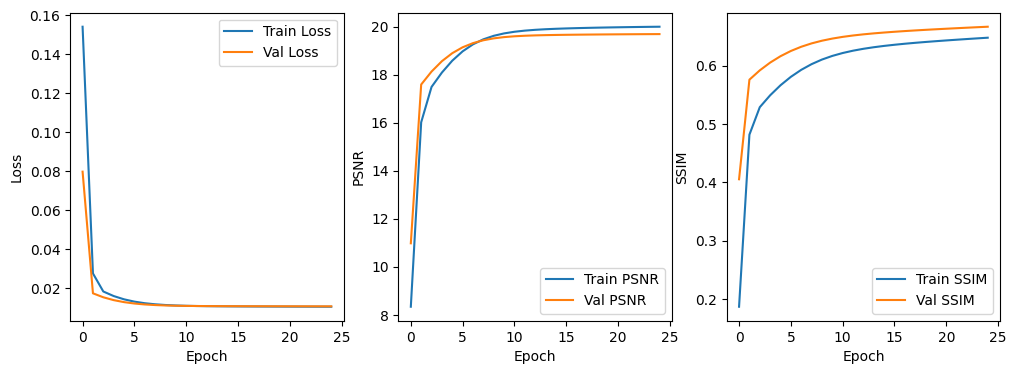

time: 284 ms (started: 2025-01-27 03:17:34 +07:00)


In [24]:
history = model.history

plt.figure(figsize=(12, 4))
    
# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
# Plot PSNR
plt.subplot(1, 3, 2)
plt.plot(history['train_metric']['psnr'], label='Train PSNR')
plt.plot(history['val_metric']['psnr'], label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()

# Plot SSIM
plt.subplot(1, 3, 3)
plt.plot(history['train_metric']['ssim'], label='Train SSIM')
plt.plot(history['val_metric']['ssim'], label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.022797433071960062..1.0379348863704219].


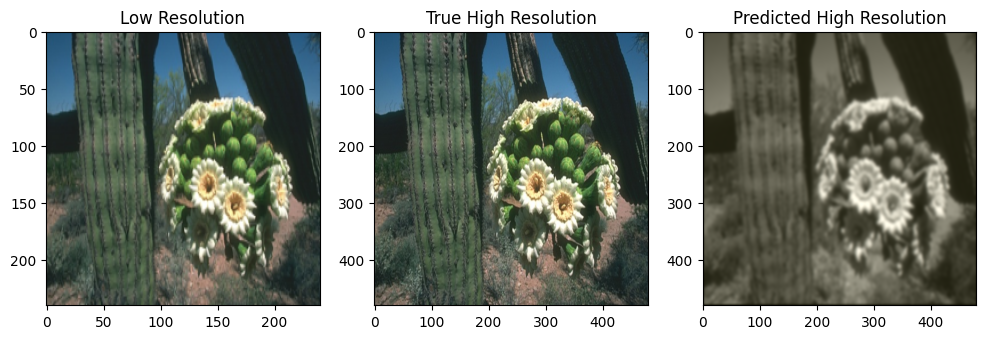

time: 1.65 s (started: 2025-01-27 03:17:34 +07:00)


In [25]:
test = X_test[1]
test = np.expand_dims(test, axis=0)

true = y_test[1]

pred = model.forward(test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test[0].transpose(1, 2, 0))
plt.title('Low Resolution')

plt.subplot(1, 3, 2)
plt.imshow(true.transpose(1, 2, 0))
plt.title('True High Resolution')

plt.subplot(1, 3, 3)
plt.imshow(pred[0].transpose(1, 2, 0))
plt.title('Predicted High Resolution')

plt.show()

In [26]:
model = SRCNN(layer_configs)
model.load_model_weights('srcnn_model_50epochs.npz')

model.train(X_train, y_train, epochs=25, learning_rate=0.05, batch_size=4, validation=(X_val, y_val), continue_training=True)

Model weights and parameters loaded from srcnn_model_50epochs.npz.npz


Epoch 1/25: 100%|██████████| 18/18 [05:25<00:00, 18.09s/step, loss=0.00993, psnr=20.2, ssim=0.661]


Epoch 1 - train_loss: 0.0099 - train_psnr: 20.2330 - train_ssim: 0.6614
Epoch 1 - val_loss: 0.0104 - val_psnr: 19.8236 - val_ssim: 0.6764


Epoch 2/25: 100%|██████████| 18/18 [05:11<00:00, 17.31s/step, loss=0.00993, psnr=20.2, ssim=0.662]


Epoch 2 - train_loss: 0.0099 - train_psnr: 20.2355 - train_ssim: 0.6617
Epoch 2 - val_loss: 0.0104 - val_psnr: 19.8252 - val_ssim: 0.6766


Epoch 3/25: 100%|██████████| 18/18 [05:23<00:00, 17.98s/step, loss=0.00992, psnr=20.2, ssim=0.662]


Epoch 3 - train_loss: 0.0099 - train_psnr: 20.2379 - train_ssim: 0.6619
Epoch 3 - val_loss: 0.0104 - val_psnr: 19.8268 - val_ssim: 0.6768


Epoch 4/25: 100%|██████████| 18/18 [05:46<00:00, 19.25s/step, loss=0.00991, psnr=20.2, ssim=0.662]


Epoch 4 - train_loss: 0.0099 - train_psnr: 20.2403 - train_ssim: 0.6622
Epoch 4 - val_loss: 0.0104 - val_psnr: 19.8284 - val_ssim: 0.6770


Epoch 5/25: 100%|██████████| 18/18 [06:06<00:00, 20.37s/step, loss=0.00991, psnr=20.2, ssim=0.663]


Epoch 5 - train_loss: 0.0099 - train_psnr: 20.2427 - train_ssim: 0.6625
Epoch 5 - val_loss: 0.0104 - val_psnr: 19.8300 - val_ssim: 0.6773


Epoch 6/25: 100%|██████████| 18/18 [06:19<00:00, 21.06s/step, loss=0.0099, psnr=20.2, ssim=0.663]


Epoch 6 - train_loss: 0.0099 - train_psnr: 20.2451 - train_ssim: 0.6628
Epoch 6 - val_loss: 0.0104 - val_psnr: 19.8316 - val_ssim: 0.6775


Epoch 7/25:  17%|█▋        | 3/18 [01:04<05:09, 20.65s/step, loss=0.01, psnr=20.1, ssim=0.657]  

In [27]:
model.save_model_weights('srcnn_model_75epochs')

Model weights and parameters saved to srcnn_model_50epochs.npz
time: 2.18 ms (started: 2025-01-27 05:32:49 +07:00)


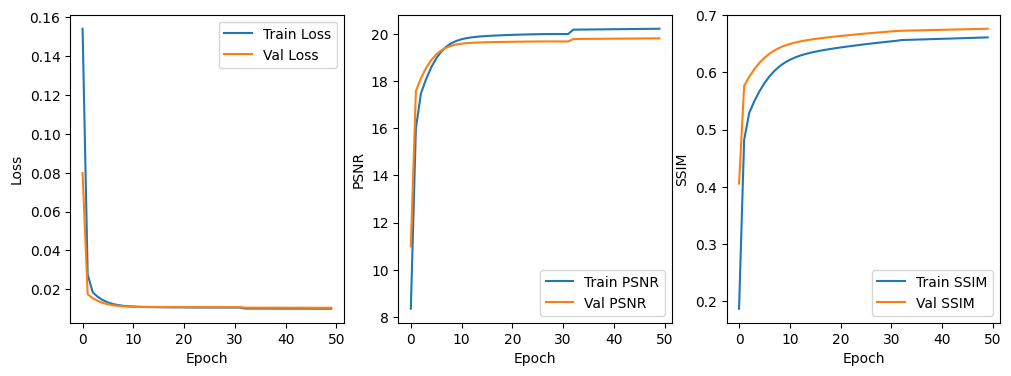

time: 265 ms (started: 2025-01-27 05:32:49 +07:00)


In [ ]:
history = model.history

plt.figure(figsize=(12, 4))
    
# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
# Plot PSNR
plt.subplot(1, 3, 2)
plt.plot(history['train_metric']['psnr'], label='Train PSNR')
plt.plot(history['val_metric']['psnr'], label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()

# Plot SSIM
plt.subplot(1, 3, 3)
plt.plot(history['train_metric']['ssim'], label='Train SSIM')
plt.plot(history['val_metric']['ssim'], label='Val SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02146568242841511..1.0311358459441857].


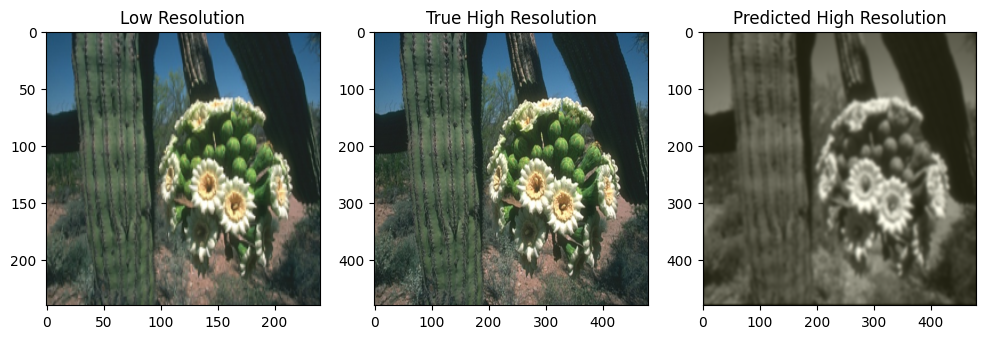

time: 1.62 s (started: 2025-01-27 05:32:49 +07:00)


In [ ]:
test = X_test[1]
test = np.expand_dims(test, axis=0)

true = y_test[1]

pred = model.forward(test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test[0].transpose(1, 2, 0))
plt.title('Low Resolution')

plt.subplot(1, 3, 2)
plt.imshow(true.transpose(1, 2, 0))
plt.title('True High Resolution')

plt.subplot(1, 3, 3)
plt.imshow(pred[0].transpose(1, 2, 0))
plt.title('Predicted High Resolution')

plt.show()

In [ ]:
model.evaluate(X_test, y_test)